purpose: analyze the output from Daniel's TWAS pipeline from TWAS (as of 20 June 2024) for all tissues- for determining whether they can be used for tsem and compare to the output from S-PrediXcan

# set-up

In [1]:
save_fig=False

In [2]:
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import statsmodels.stats.multitest
import numpy as np

In [3]:
os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/')

In [4]:
from rca_functions import manhattan

In [5]:
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [6]:
IBM=['#648FFF','#785EF0','#DC267F','#FE6100','#FFB000']
colour_dict={
    'ext':IBM[1],
    'ext_alt':IBM[0],
    'loco':IBM[4],
    'loco_alt':IBM[3],
    'shared':IBM[2],
    'other':'#CCCCCC',
    'smkinit_pc1':IBM[1],
    'smkinit_pc1_alt':IBM[0],
    'cigday_pc1':IBM[2],
    'cigday_pc1_alt':'#930741'
}

In [7]:
loco_dir='loco_twas_dan/'

In [8]:
#downloaded from ensembl BioMart on 9 July 2024 for mRatBN7.2
gene_tbl=pd.read_csv(loco_dir+'biomart.mRatBN7.2.gene_map.gtf.gz',compression='gzip',sep='\t')
transcript_tbl=pd.read_csv(loco_dir+'biomart.mRatBN7.2.transcript_map.gtf.gz',compression='gzip',sep='\t')
#downloaded from ensembl- doesn't have gene symbol/transcript name, but does have other info that may be interesting
feat_meta_tbl=pd.read_csv(loco_dir+'Rattus_norvegicus.mRatBN7.2.112.gtf.gz',compression='gzip',skiprows=5,sep='\t',header=None)
feat_meta_tbl.columns=['seqname','source','feature','start','end','score','strand','frame','attribute']
#locomotor activity TWAS calculated by FUSION by Dan Munroe
tbl=pd.read_csv(loco_dir+'regressedlr_combined_locomotor.dat',sep='\t')
tbl['TISSUE']=[s.split('.')[1] for s in tbl.PANEL]
tbl['TYPE_MOD']=[s.split('.')[2] for s in tbl.PANEL]

/tmp/ipykernel_2621179/1650281201.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  feat_meta_tbl=pd.read_csv(loco_dir+'Rattus_norvegicus.mRatBN7.2.112.gtf.gz',compression='gzip',skiprows=5,sep='\t',header=None)


# functions

In [9]:
def extract_IDs(annot, type=None):
    if (type=='gene'):
        #print('returning ENSRNOG')
        ls=[x for x in re.split('[:.]', annot) if x.startswith('ENSRNOG')]
        if len(ls)>0:
            return(ls[0])
    elif (type=='transcript'):
        ls=[x for x in re.split('[:.]', annot) if x.startswith('ENSRNOT')]
        if len(ls)>0:
            return(ls[0])
    else:
        return [x for x in re.split('[:.]', annot) if x.startswith('ENSR')]

In [10]:
def format_chr(element):
    try:
        return(int(element))
    except ValueError:
        return(element)

In [ ]:
def manhattan(pval, pos, chr, label,
              chrs_plot=None, chrs_names=None,
              cut=2,
              colors=['k', '0.5'],
              title='Title',
              xlabel='chromosome',
              ylabel='-log10(p-value)',
              top=0,
              lines=[10, 15],
              lines_colors=['g', 'r'],
              lines_styles=['-', '--'],
              lines_widths=[1, 1],
              zoom=None,
              scaling='-log10',
              plot_grid_lines=True,
              **kwargs):
    """
    Creates a Manhattan plot across chromosomes based on their p-values.

    Parameters:
    - pval (array-like): List or array of p-values for genomic variants.
    - pos (array-like): Corresponding positions of the variants on their respective chromosomes.
    - chr (array-like): Chromosome numbers for each variant.
    - label (str): Label for the dataset, used for plotting and legend.
    - chrs_plot (list, optional): Specific chromosomes to include in the plot; defaults to plotting all unique chromosomes.
    - chrs_names (list, optional): Names to be displayed along the x-axis for chromosomes; automatically generated if not provided.
    - cut (float): Cutoff value for -log10(p-values) to display; variants below this value are not plotted.
    - colors (list): Colors to use for plotting points, alternating between chromosomes.
    - title (str): Title of the plot.
    - xlabel (str): Label for the x-axis.
    - ylabel (str): Label for the y-axis, indicating the transformation applied to p-values.
    - top (float): Maximum value for the y-axis; calculated from data if not provided.
    - lines (list): List of y-values where horizontal lines should be drawn.
    - lines_colors (list): Colors for each horizontal line listed in 'lines'.
    - lines_styles (list): Line styles for each horizontal line.
    - lines_widths (list): Widths of each horizontal line.
    - zoom (tuple): Tuple (chromosome, center position, range) defining a zoom region on a specific chromosome.
    - scaling (str): Method of scaling p-values; options are '-log10' for negative log-transform or 'none' for raw p-values.
    - plot_grid_lines (bool): Whether to draw grid lines at chromosome boundaries.
    - **kwargs: Additional keyword arguments passed to the plt.plot function.

    Returns:
    matplotlib.pyplot: Configured plot object ready to be shown or saved.
    """
    # Generate figure
    shift = np.array([0.0])
    plt.clf()

    # Generate list of chromosomes for chr_plot from chr if chr_plot doesn't exist
    if chrs_plot is None:
        chrs_list = np.unique(chr)
        if isinstance(chrs_list[0], str):
            chrs_list = sorted_nicely(chrs_list)  # Assuming sorted_nicely is defined elsewhere
        else:
            chrs_list.sort()
    # Create labels from chr for chromosomes if not provided
    if chrs_names is None:
        chrs_names = [str(chrs_list[i]) for i in range(len(chrs_list))]

    # Iteratively plot each chromosome's data
    plot_positions = len(chrs_list) == 1
    for ii, i in enumerate(chrs_list):
        plt.subplot(1, 1, 1)
        filt = np.where(chr == i)[0]
        x = shift[-1] + pos[filt]
        y = -np.log10(pval[filt]) if scaling == '-log10' else pval[filt]
        plt.plot(x[y > cut], y[y > cut], '.', color=colors[ii % len(colors)], **kwargs)
        shift_f = np.max(x)

        # Apply zoom if specified
        zoom_shift = zoom[1] + shift[-1] if zoom is not None and zoom[0] == i else 0
        shift = np.append(shift, np.max([shift_f, 0]))
        #add gridlines to figure
        if plot_grid_lines:
            plt.plot([shift[-1], shift[-1]], [0, 1000], '-', lw=0.5, color='lightgray', **kwargs)
            plt.xlim([0, shift[-1]])

    # Adjust top boundary of the plot
    if top == 0:
        top = np.ceil(np.max(-np.log10(pval))) if scaling == '-log10' else np.ceil(np.max(pval))

    # Set labels and plot horizontal lines
    shift_label = shift[-1]
    shift = (shift[1:] + shift[:-1]) / 2
    for i, y in enumerate(lines):
        plt.axhline(y=y, color=lines_colors[i], linestyle=lines_styles[i], linewidth=lines_widths[i])

    # Final plot adjustments
    plt.ylim([cut, top])
    plt.title(title)
    if not plot_positions:
        plt.xticks(shift, chrs_names)
    plt.text(shift_label * 0.95, top * 0.95, label,
             verticalalignment='top', horizontalalignment='right')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

    # Apply zoom if specified
    if zoom is not None:
        plt.xlim([zoom_shift - zoom[2], zoom_shift + zoom[2]])

    return plt


# Rat TWAS Manhattan

## format trascript table

In [11]:
tbl['ID_ls']=tbl['ID'].apply(extract_IDs)
tbl['gene_id']=tbl['ID'].apply(extract_IDs,type='gene')
tbl['tran_id']=tbl['ID'].apply(extract_IDs,type='transcript')

In [12]:
#add in gene name
t=tbl.merge(gene_tbl[['Gene stable ID','Gene name']], left_on='gene_id',right_on='Gene stable ID',how='left').drop('Gene stable ID', axis=1)
t=t.merge(transcript_tbl[['Transcript stable ID','Transcript name']], left_on='tran_id',right_on='Transcript stable ID',how='left').drop('Transcript stable ID', axis=1)
#t_exp=t[t.TYPE_MOD=='expression']

In [13]:
pd.Series(list(map(len, tbl['ID_ls']))).describe()
#there's only max 2 IDs- transcript and gene

count    150018.000000
mean          1.262788
std           0.440150
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           2.000000
dtype: float64

## analyze TWAS output

In [14]:
#types of protein modifications assayed
set(tbl.TYPE_MOD)

{'alt_TSS', 'alt_polyA', 'expression', 'isoforms', 'splicing', 'stability'}

In [15]:
twas_dict={}
for k in set(t.TISSUE):
    t_sub=t[(t.TISSUE==k)&(~t['TWAS.P'].isna())].reset_index()
    t_sub['TWAS.Q']=statsmodels.stats.multitest.fdrcorrection(t_sub['TWAS.P'],alpha=0.05,method='indep',is_sorted=False)[1]
    twas_dict[k]=t_sub
    t_sub=t_sub[t_sub.TYPE_MOD=='expression'].reset_index()
    t_sub['TWAS.Q']=statsmodels.stats.multitest.fdrcorrection(t_sub['TWAS.P'],alpha=0.05,method='indep',is_sorted=False)[1]
    twas_dict[k+'_exp']=t_sub

In [16]:
tissue_label={'BLA':'Basolateral amygdala',
'Brain':'Brain hemisphere',
'IL':'Infralimbic cortex',
'LHb':'Lateral habenula',
'NAcc':'Nucleus accumbens core',
'NAcc2':'Nucleus accumbens core 2',
'OFC':'Orbitofrontal cortex',
'PL':'Prelimbic cortex',
'PL2':'Prelimbic cortex 2',
'Adipose':'Adipose',
'Eye':'Eye',
'Liver':'Liver'}

In [17]:
set(t.TISSUE)

{'Adipose',
 'BLA',
 'Brain',
 'Eye',
 'IL',
 'LHb',
 'Liver',
 'NAcc',
 'NAcc2',
 'OFC',
 'PL',
 'PL2'}

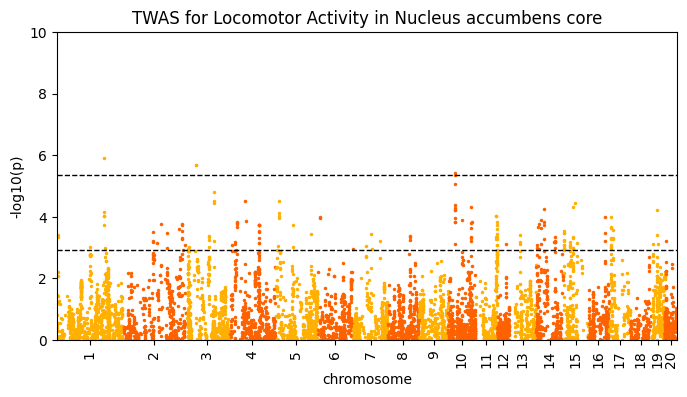

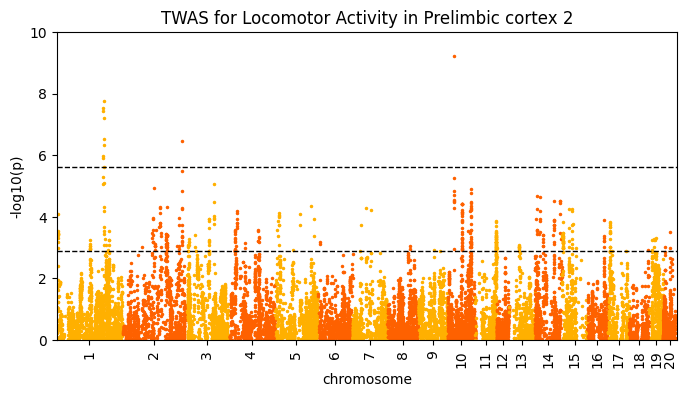

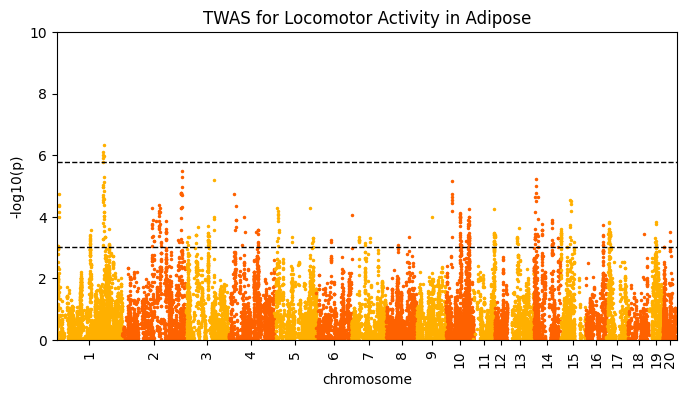

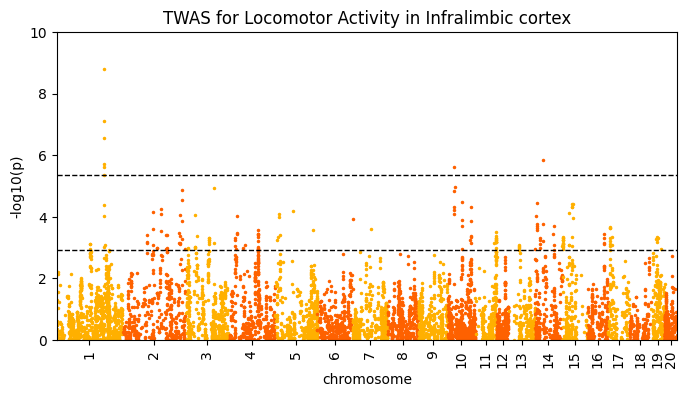

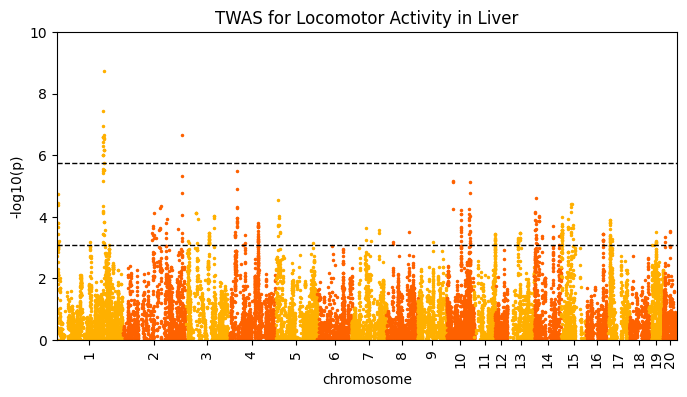

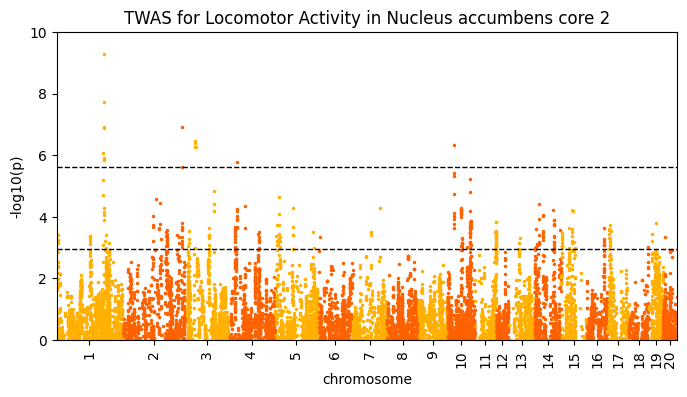

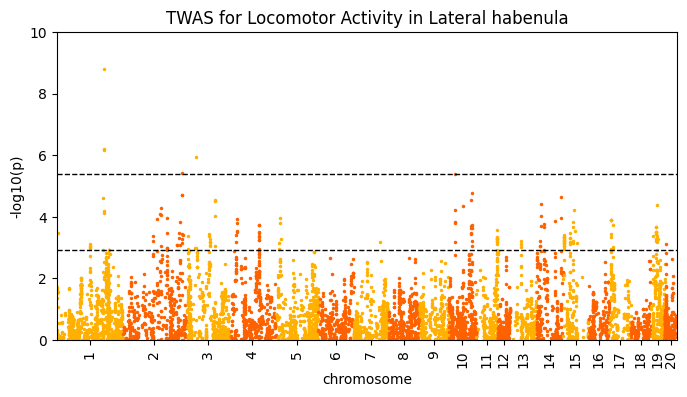

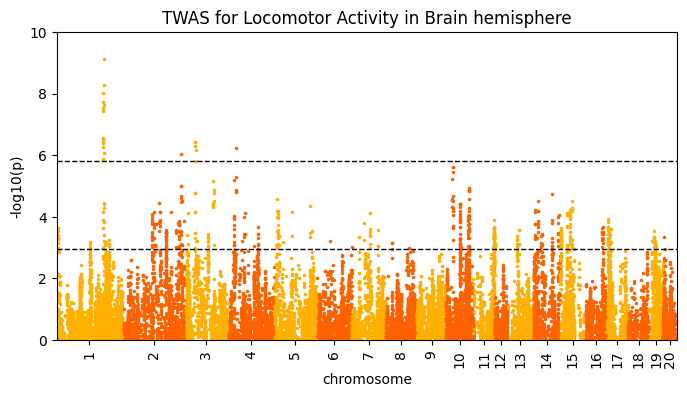

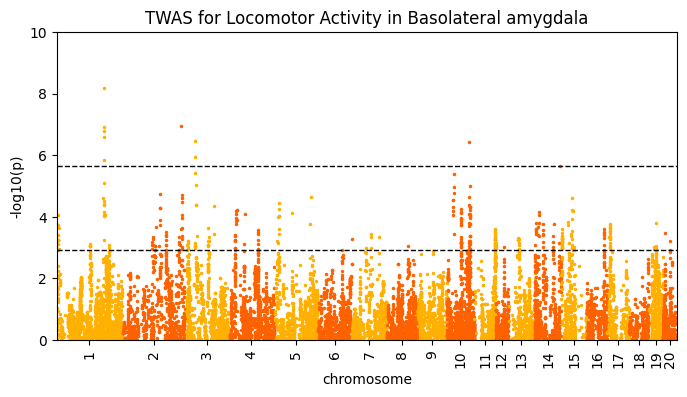

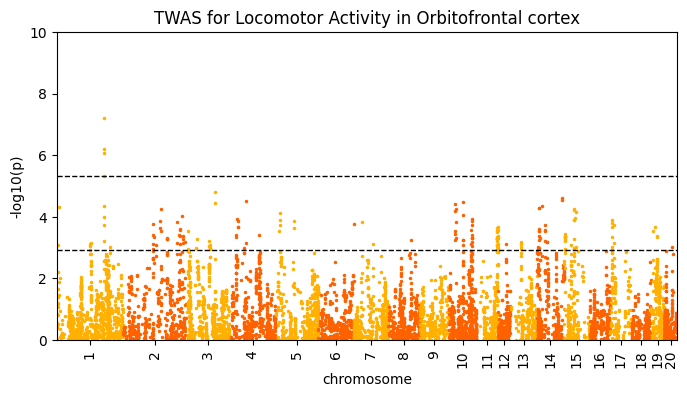

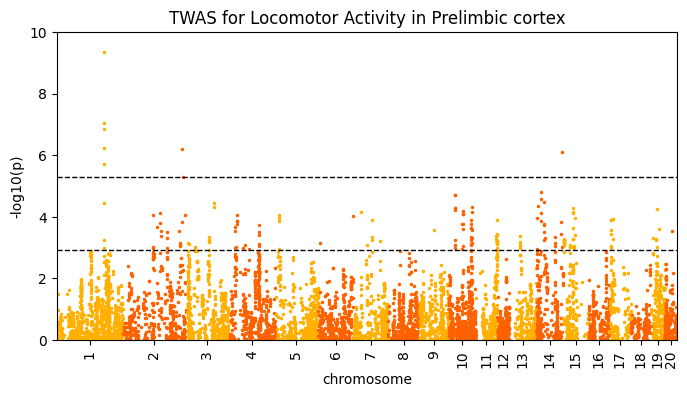

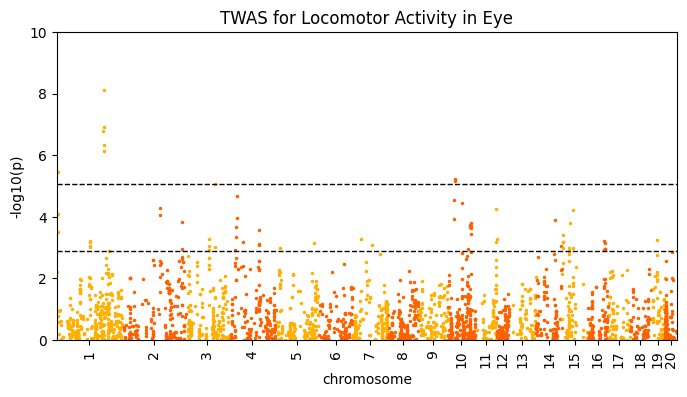

In [64]:
for k in set(t.TISSUE):  
    cutoff=-np.log10(max(twas_dict[k][twas_dict[k]['TWAS.Q']<0.05]['TWAS.P']))
    cutoff2=-np.log10(max(twas_dict[k][twas_dict[k]['TWAS.P']<0.05/len(twas_dict[k])]['TWAS.P']))
    fig=plt.figure(figsize=(8,4))
    #fig, ax=plt.subplots(figsize=(10,4))
    j='loco'
    manhattan(pval=twas_dict[k]['TWAS.P'],pos=twas_dict[k]['P0'],chr=twas_dict[k]['CHR'],label='',
                        cut=0,lines=[cutoff, cutoff2],lines_colors=['black', 'black'], colors=[colour_dict[j], colour_dict[j+'_alt']],
                        lines_widths = [1,1], lines_styles = ["--","--"], markersize=3,top=10, plot_grid_lines=False)
    fig=plt.title('TWAS for Locomotor Activity in '+tissue_label[k])
    fig=plt.ylabel('-log10(p)')
    plt.margins(x=0)
    #commented out- use to turn into miami plot
    #plt.gca().invert_yaxis()
    #plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
    fig=plt.xticks(rotation='vertical')
    if (save_fig):
        plt.savefig('figures/manhattan_TWAS_'+j+'_tissue'+k+'.png',dpi=600,bbox_inches='tight')

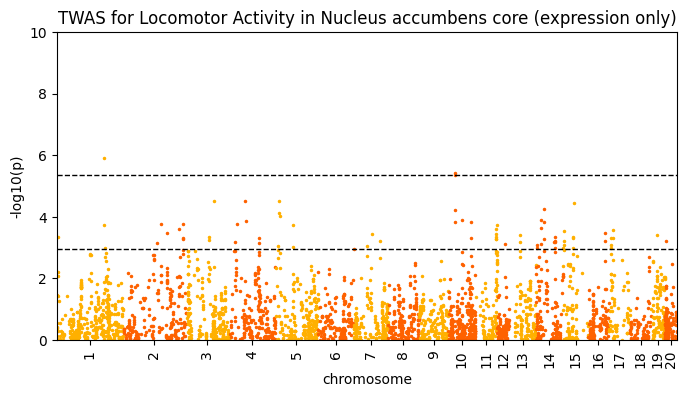

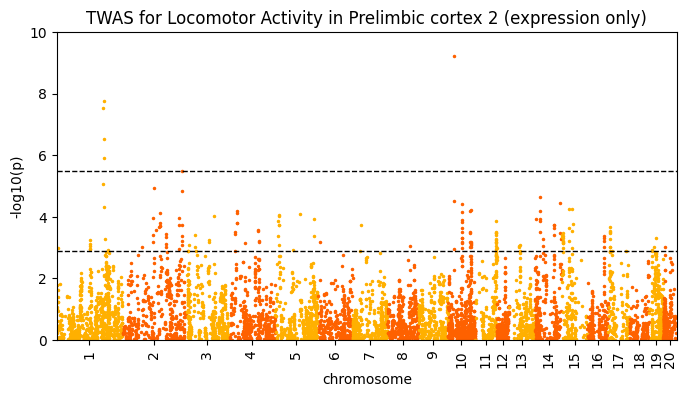

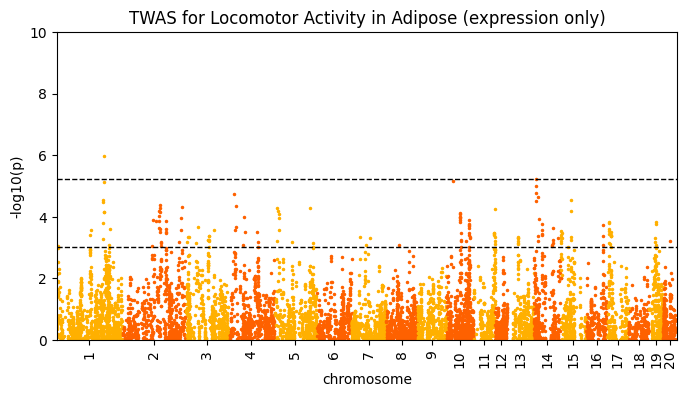

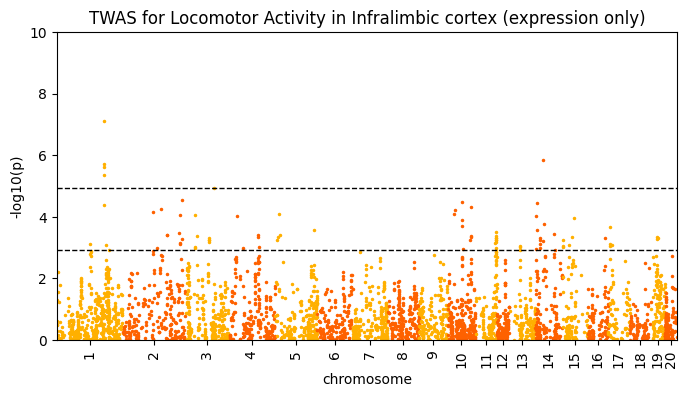

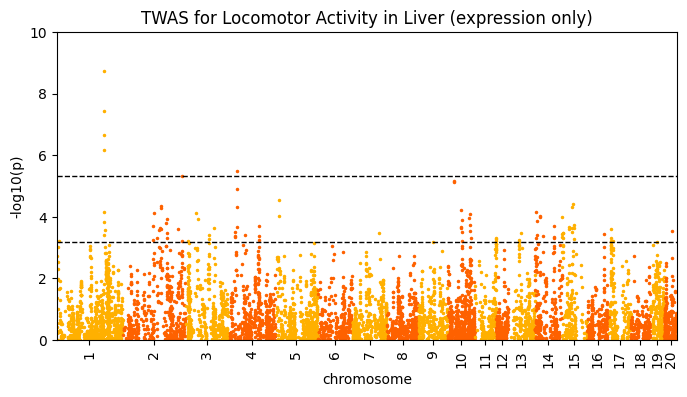

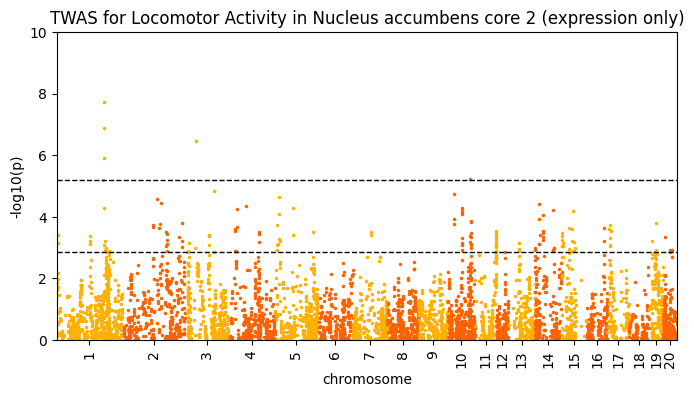

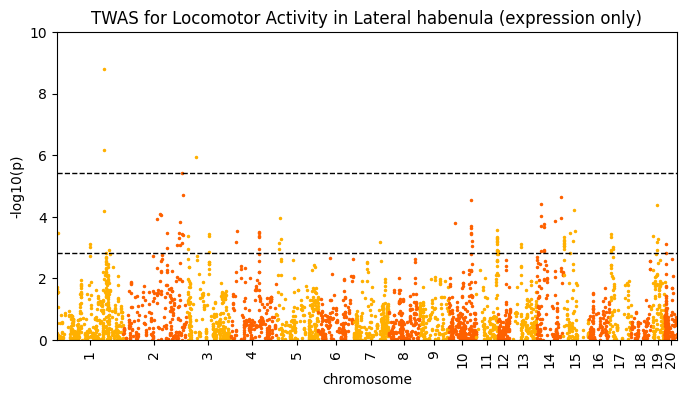

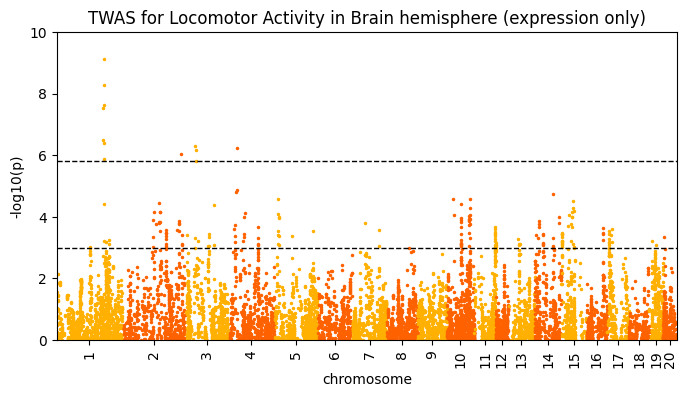

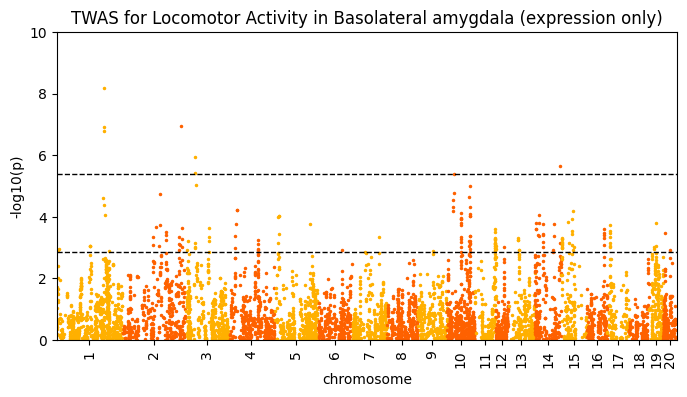

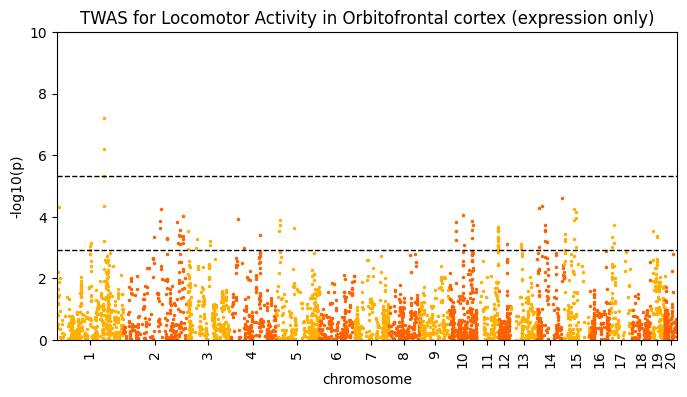

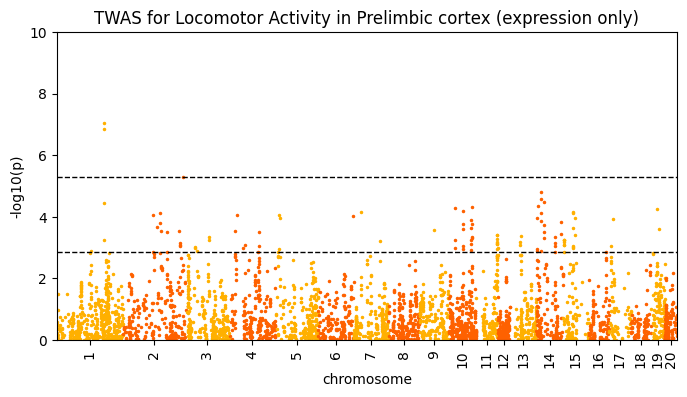

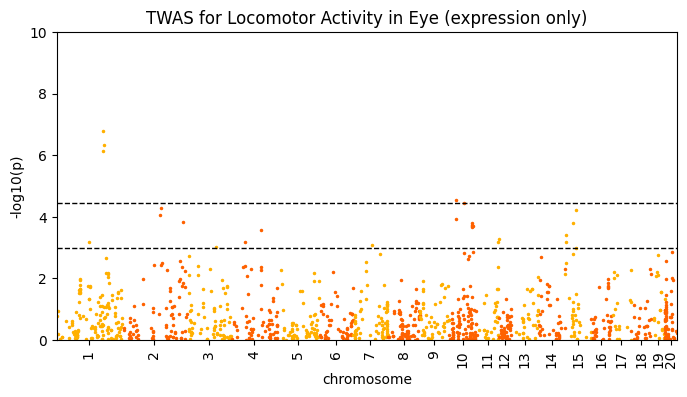

In [66]:
for h in set(t.TISSUE):
    k=h+'_exp'
    cutoff=-np.log10(max(twas_dict[k][twas_dict[k]['TWAS.Q']<0.05]['TWAS.P']))
    cutoff2=-np.log10(max(twas_dict[k][twas_dict[k]['TWAS.P']<0.05/len(twas_dict[k])]['TWAS.P']))
    fig=plt.figure(figsize=(8,4))
    #fig, ax=plt.subplots(figsize=(10,4))
    j='loco'
    manhattan(pval=twas_dict[k]['TWAS.P'],pos=twas_dict[k]['P0'],chr=twas_dict[k]['CHR'],label='',
                        cut=0,lines=[cutoff, cutoff2],lines_colors=['black', 'black'], colors=[colour_dict[j], colour_dict[j+'_alt']],
                        lines_widths = [1,1], lines_styles = ["--","--"], markersize=3,top=10, plot_grid_lines=False)
    fig=plt.title('TWAS for Locomotor Activity in '+tissue_label[h]+' (expression only)')
    fig=plt.ylabel('-log10(p)')
    plt.margins(x=0)
    #commented out- use to turn into miami plot
    #plt.gca().invert_yaxis()
    #plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
    fig=plt.xticks(rotation='vertical')
    if save_fig:
        plt.savefig('figures/manhattan_TWAS_'+j+'_tissue'+k+'_expression_only.png',dpi=600,bbox_inches='tight')

# human S-Predixcan Manhattan

## runscript

In [ ]:
#script (bash) for running S-PrediXcan
#Haki's lab recommends using MASHR but in EXT1.0 paper they used elastic net- so used that- copied from Sandra's lab TSCC MetaXcan folder
'''
cd /tscc/projects/ps-palmer/brittany/MetaXcan/GTEx/brain_models/
db_list=(`ls *.db`)

cd /tscc/projects/ps-palmer/brittany/MetaXcan/
source activate imlabtools

m=${db_list[$SLURM_ARRAY_TASK_ID-1]}
echo $m

software/SPrediXcan.py \
--model_db_path  "GTEx/brain_models/"$m \
--covariance GTEx/gtex_v8_expression_elastic_net_snp_smultixcan_covariance.txt.gz \
--gwas_file /tscc/projects/ps-palmer/brittany/SUD_cross_species/ext_sumstat_2019/FINAL.EXT_COMMON_FACTOR.EXTERNALIZING.20191014.PREPARED.wFREQ.A1.txt.gz \
--snp_column SNP \
--effect_allele_column A1 \
--non_effect_allele_column A2 \
--beta_column BETA.A1 \
--pvalue_column P \
--output_file "results/predixcan_externalizing2019_"${m##*/}".csv"
'''

## set-up

In [27]:
# one used for magma- loses a lot of genes :/
gene_loc=pd.read_csv('../magma_v1/NCBI38/NCBI38.gene.loc',sep='\t',header=None)
gene_loc.columns=['ID','CHR','START','STOP','STAND','GENE_NAME']

In [28]:
gene_loc_mart=pd.read_csv('/tscc/nfs/home/bsleger/bsl/MetaXcan/biomart_gene_loc.txt',sep='\t')
CHR=[1,'1',10,'10',11, '11', 12, '12', '13', 14, '14', 15, '15', 16, '16', 17, '17', '18', 19, '19', 2, '2', '20', '21', '22', 3, '3', 4, '4', 5, '5',6 ,'6', 7, '7', 8,'8',9,'9','X','Y']
gene_loc_mart=gene_loc_mart[gene_loc_mart['Chromosome/scaffold name'].isin(CHR)]
gene_loc_mart['Chromosome/scaffold name']=(gene_loc_mart['Chromosome/scaffold name'].apply(format_chr))


/tmp/ipykernel_25423/2292627534.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  gene_loc_mart=pd.read_csv('/tscc/nfs/home/bsleger/bsl/MetaXcan/biomart_gene_loc.txt',sep='\t')


In [129]:
pred_path='/tscc/nfs/home/bsleger/bsl/SUD_cross_species/ext1_predixcan/'

In [153]:
import pathlib


In [164]:
# use MAGMA gene loci
pred_dict_gene_loc={}
for f in os.listdir(pred_path):
    t_sub=pd.read_csv(pred_path+f,sep=',').drop('pred_perf_qval',axis=1)
    t_sub['Q']=statsmodels.stats.multitest.fdrcorrection(t_sub['pvalue'],alpha=0.05,method='indep',is_sorted=False)[1]
    t_sub=t_sub.merge(gene_loc[['GENE_NAME','CHR','START','STOP']],left_on='gene_name',right_on='GENE_NAME',how='left')
    x=len(t_sub)
    t_sub=t_sub.dropna(axis=0).reset_index()
    print(str(x-len(t_sub))+' genes lost from adding loci')
    g=f[31:len(f)-7]
    pred_dict_gene_loc[g]=t_sub

675 genes lost from adding loci
816 genes lost from adding loci
950 genes lost from adding loci
834 genes lost from adding loci
713 genes lost from adding loci
628 genes lost from adding loci
832 genes lost from adding loci
635 genes lost from adding loci
477 genes lost from adding loci
874 genes lost from adding loci
526 genes lost from adding loci
746 genes lost from adding loci
563 genes lost from adding loci


In [165]:
#use biomart
pred_dict={}
for f in os.listdir(pred_path):
    t_sub=pd.read_csv(pred_path+f,sep=',').drop('pred_perf_qval',axis=1)
    t_sub['Q']=statsmodels.stats.multitest.fdrcorrection(t_sub['pvalue'],alpha=0.05,method='indep',is_sorted=False)[1]
    t_sub=t_sub.merge(gene_loc_mart[['Gene name','Chromosome/scaffold name','Gene start (bp)','Gene end (bp)']],left_on='gene_name',right_on='Gene name',how='left')
    x=len(t_sub)
    t_sub=t_sub.dropna(axis=0).reset_index()
    print(str(x-len(t_sub))+' genes lost from adding loci')
    g=f[31:len(f)-7]
    pred_dict[g]=t_sub

595 genes lost from adding loci
692 genes lost from adding loci
835 genes lost from adding loci
745 genes lost from adding loci
617 genes lost from adding loci
543 genes lost from adding loci
729 genes lost from adding loci
553 genes lost from adding loci
406 genes lost from adding loci
750 genes lost from adding loci
455 genes lost from adding loci
645 genes lost from adding loci
464 genes lost from adding loci


In [161]:
save_fig=True

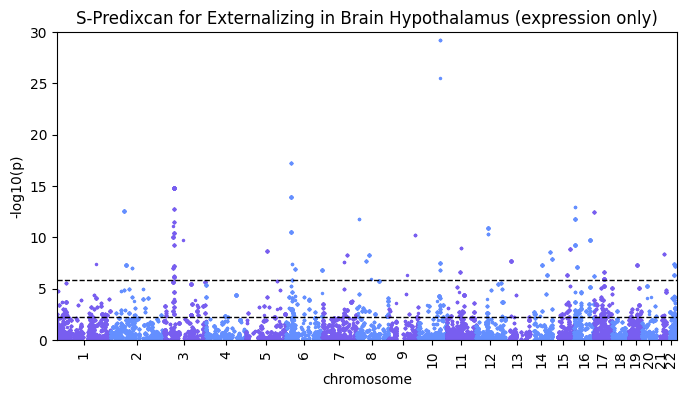

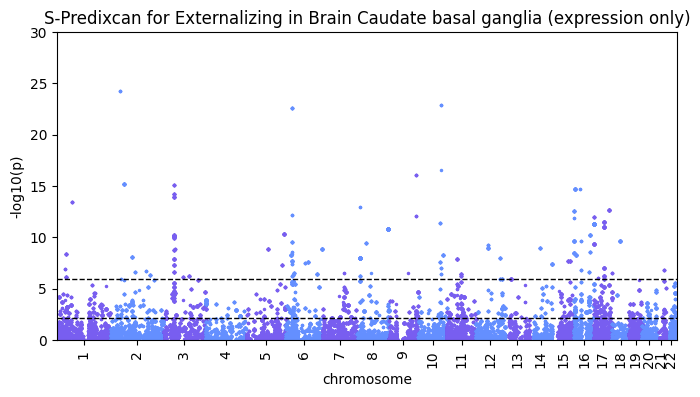

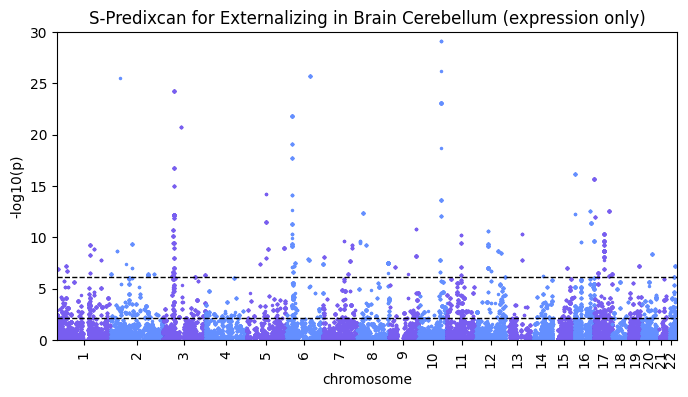

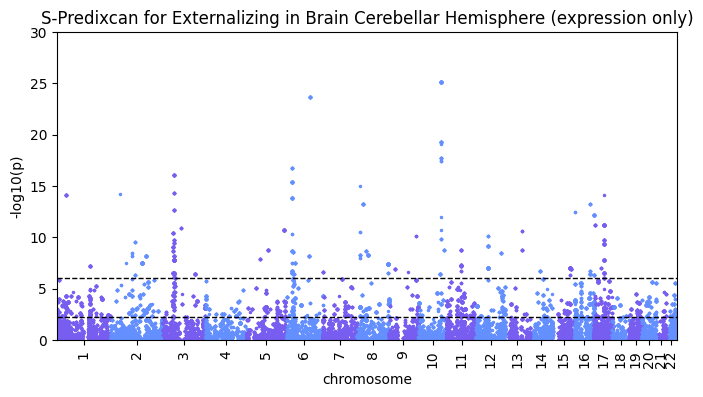

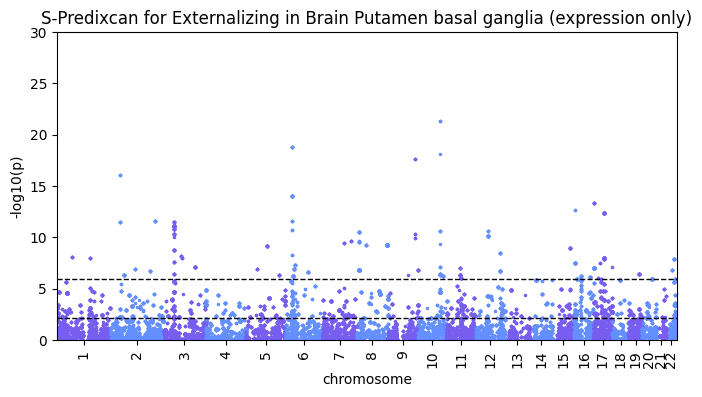

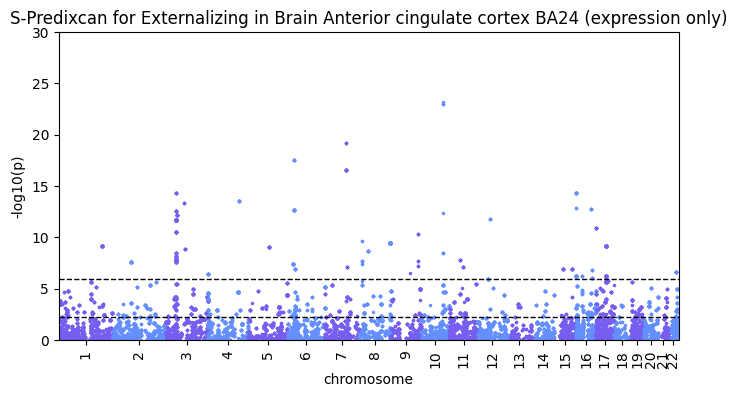

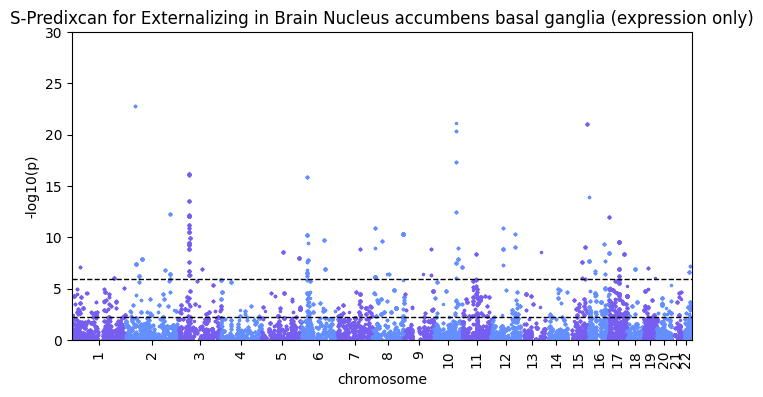

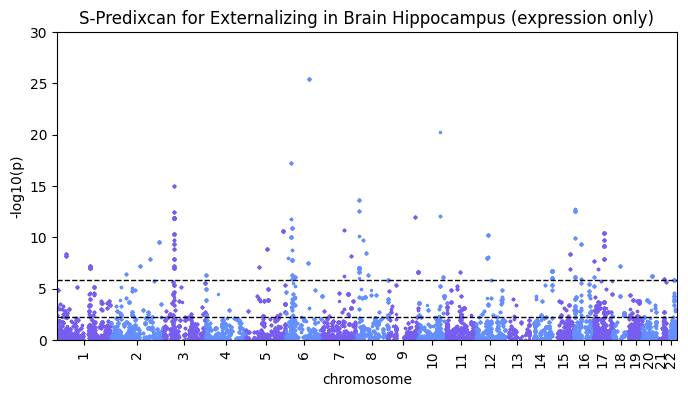

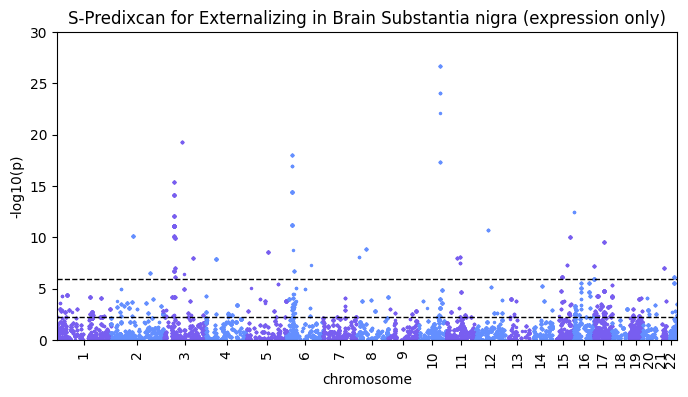

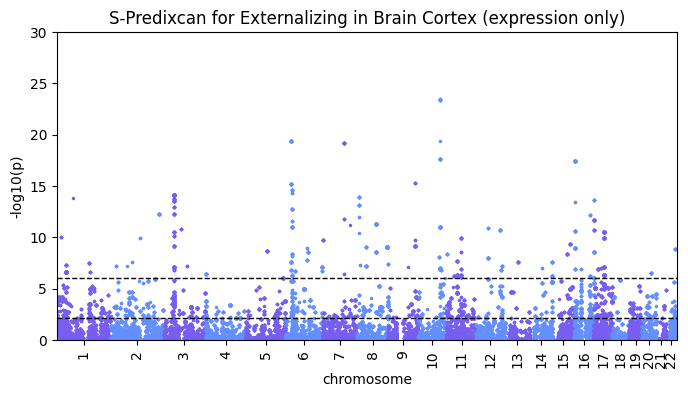

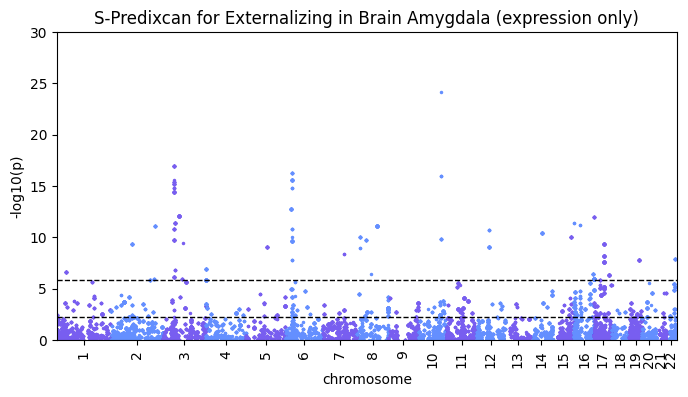

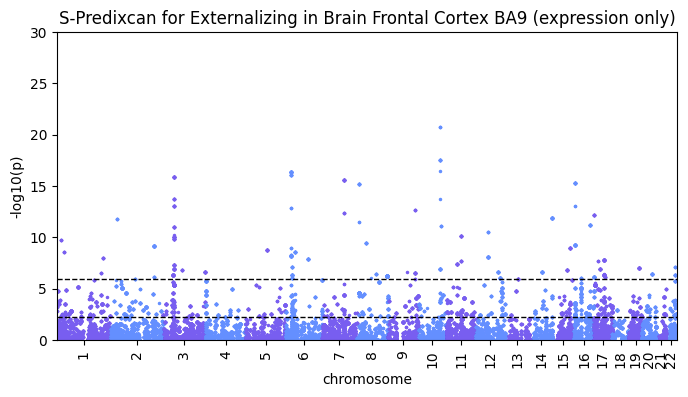

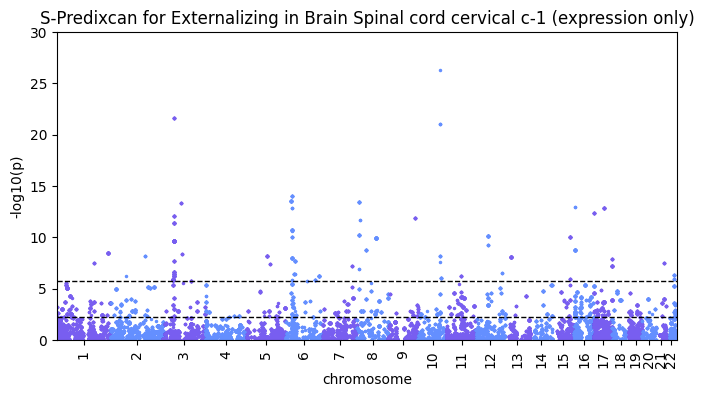

In [166]:
#biomart
j='ext'
for k in pred_dict.keys():
    cutoff=-np.log10(max(pred_dict[k][pred_dict[k]['Q']<0.05]['pvalue']))
    cutoff2=-np.log10(max(pred_dict[k][pred_dict[k]['pvalue']<0.05/len(pred_dict[k])]['pvalue']))
    fig=plt.figure(figsize=(8,4))
    #fig, ax=plt.subplots(figsize=(10,4))
    manhattan(pval=pred_dict[k]['pvalue'],pos=pred_dict[k]['Gene start (bp)'],chr=pred_dict[k]['Chromosome/scaffold name'],label='',
                        cut=0,lines=[cutoff, cutoff2],lines_colors=['black', 'black'], colors=[colour_dict[j], colour_dict[j+'_alt']],
                        lines_widths = [1,1], lines_styles = ["--","--"], markersize=3,top=30, plot_grid_lines=False)
    fig=plt.title('S-Predixcan for Externalizing in '+k.replace('_', ' ')+' (expression only)')
    fig=plt.ylabel('-log10(p)')
    plt.margins(x=0)
    #commented out- use to turn into miami plot
    #plt.gca().invert_yaxis()
    #plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
    fig=plt.xticks(rotation='vertical')
    if save_fig:
        plt.savefig('figures/manhattan_predixcan_'+j+'_tissue'+k+'_expression_only.png',dpi=600,bbox_inches='tight')

In [143]:
set(pred_dict[k]['Chromosome/scaffold name'])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}

In [139]:
set(pred_dict_gene_loc[k]['CHR'])

{'1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9'}

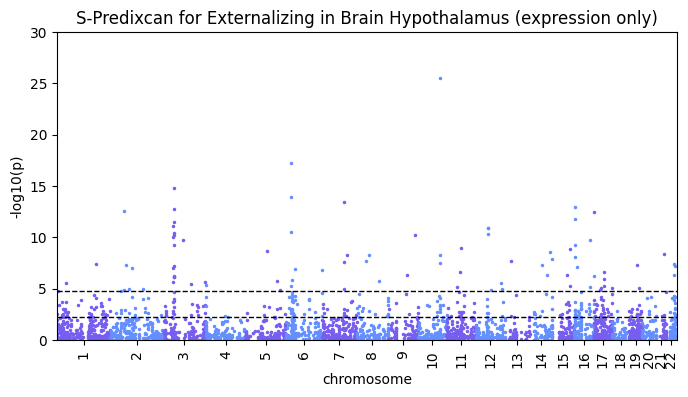

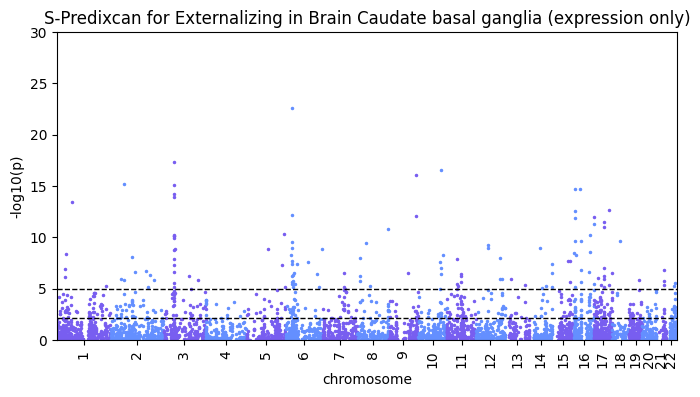

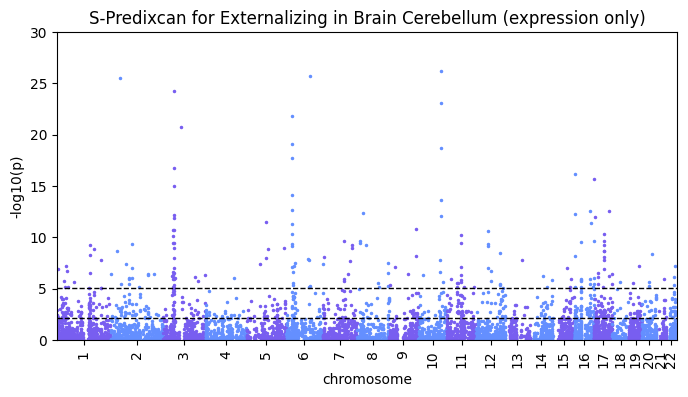

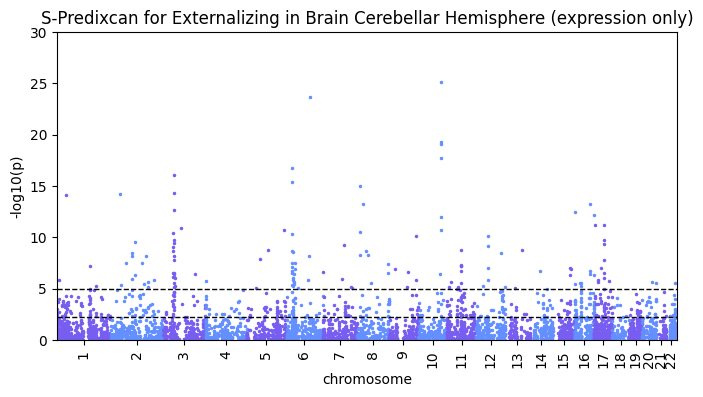

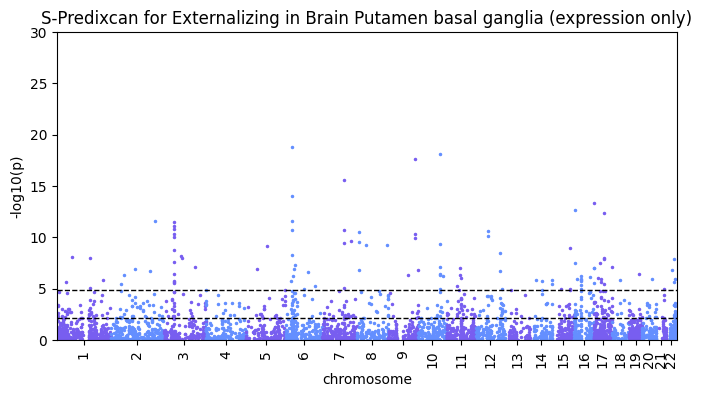

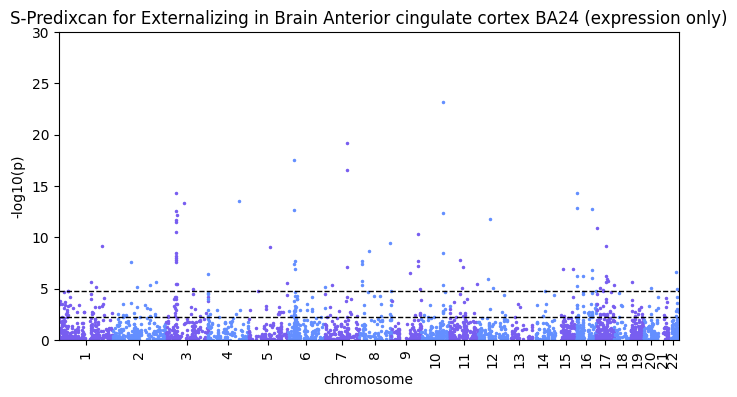

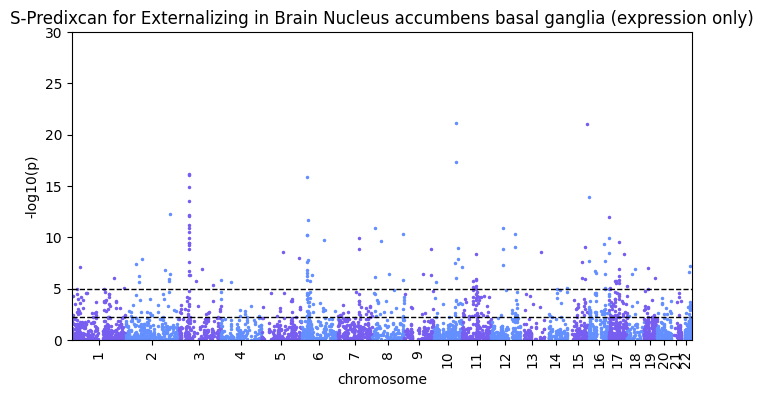

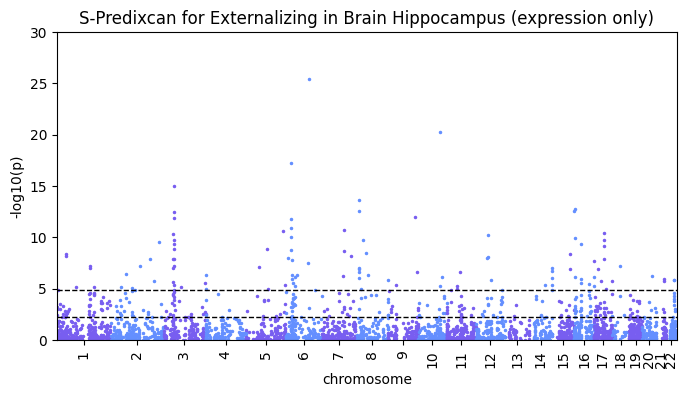

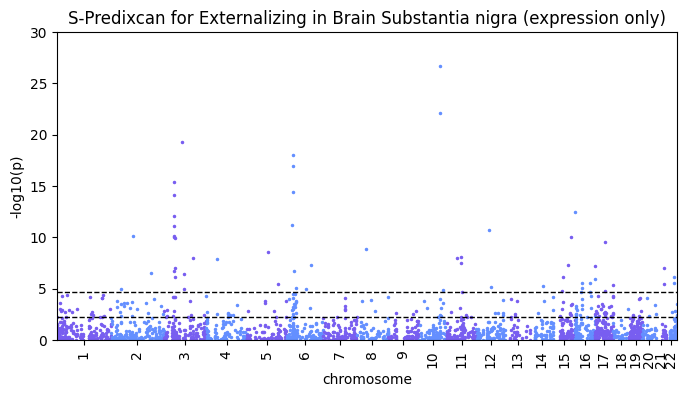

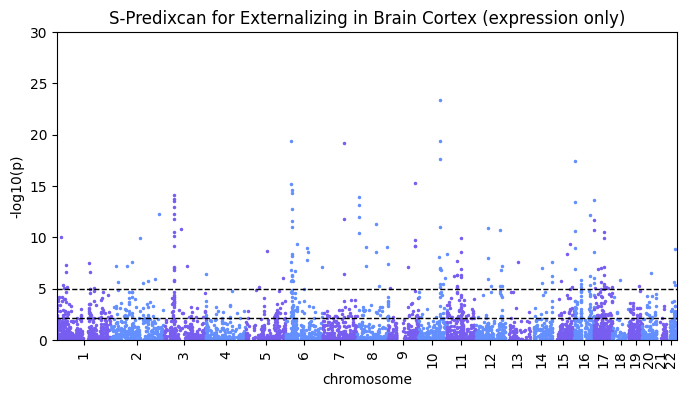

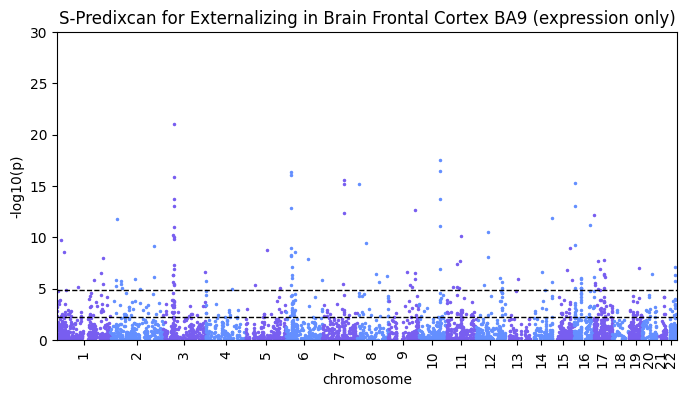

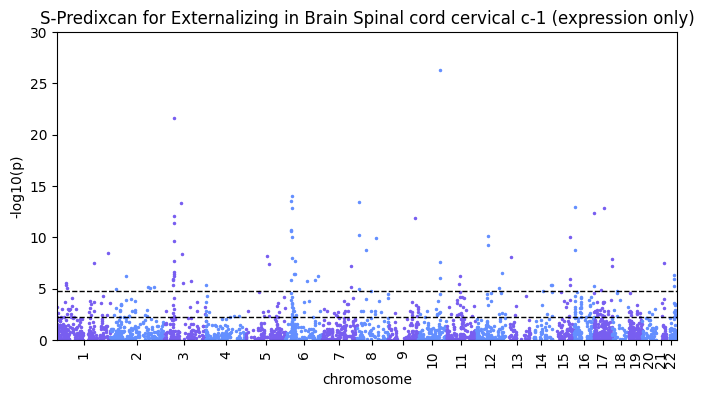

In [135]:
j='ext'
for k in pred_dict_gene_loc.keys():
    cutoff=-np.log10(max(pred_dict_gene_loc[k][pred_dict_gene_loc[k]['Q']<0.05]['pvalue']))
    cutoff2=-np.log10(max(pred_dict_gene_loc[k][pred_dict_gene_loc[k]['pvalue']<0.05/len(pred_dict_gene_loc[k])]['pvalue']))
    fig=plt.figure(figsize=(8,4))
    #fig, ax=plt.subplots(figsize=(10,4))
    manhattan(pval=pred_dict_gene_loc[k]['pvalue'],pos=pred_dict_gene_loc[k]['START'],chr=pred_dict_gene_loc[k]['CHR'],label='',
                        cut=0,lines=[cutoff, cutoff2],lines_colors=['black', 'black'], colors=[colour_dict[j], colour_dict[j+'_alt']],
                        lines_widths = [1,1], lines_styles = ["--","--"], markersize=3,top=30, plot_grid_lines=False)
    fig=plt.title('S-Predixcan for Externalizing in '+k.replace('_', ' ')+' (expression only)')
    fig=plt.ylabel('-log10(p)')
    plt.margins(x=0)
    #commented out- use to turn into miami plot
    #plt.gca().invert_yaxis()
    #plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
    fig=plt.xticks(rotation='vertical')


In [146]:
len(pred_dict_gene_loc.keys())

12

# Map Rat to Human

In [33]:
ortho=pd.read_csv('/tscc/projects/ps-palmer/brittany/orthology_ref_tbls/ORTHOLOGY-ALLIANCE_COMBINED_2024.tsv',sep='\t',skiprows=15)
#downloaded from https://www.alliancegenome.org/downloads#orthology on 11 June 2024
#filter for rat-human
ortho=ortho[(ortho['Gene1SpeciesName']=='Rattus norvegicus')&(ortho['Gene2SpeciesName']=='Homo sapiens')]
#filter for best match
ortho=ortho[ortho['IsBestScore']=='Yes']
ortho_best=ortho[ortho['IsBestScore']=='Yes']

In [141]:
twas_dict['PL']

index                 PANEL  \
0      16452  RatGTEx.PL.alt_polyA   
1      16453  RatGTEx.PL.alt_polyA   
2      16454  RatGTEx.PL.alt_polyA   
3      16455  RatGTEx.PL.alt_polyA   
4      16456  RatGTEx.PL.alt_polyA   
...      ...                   ...   
7681  149155  RatGTEx.PL.stability   
7682  149156  RatGTEx.PL.stability   
7683  149157  RatGTEx.PL.stability   
7684  149158  RatGTEx.PL.stability   
7685  149159  RatGTEx.PL.stability   

                                                   FILE  \
0     data/WEIGHTS/PL/alt_polyA/ENSRNOG00000010967.g...   
1     data/WEIGHTS/PL/alt_polyA/ENSRNOG00000011931.g...   
2     data/WEIGHTS/PL/alt_polyA/ENSRNOG00000011931.g...   
3     data/WEIGHTS/PL/alt_polyA/ENSRNOG00000013949.g...   
4     data/WEIGHTS/PL/alt_polyA/ENSRNOG00000013949.g...   
...                                                 ...   
7681  data/WEIGHTS/PL/stability/ENSRNOG00000053288.w...   
7682  data/WEIGHTS/PL/stability/ENSRNOG00000054549.w...   
7683  data/WEIGHTS/PL/stability/ENSRNOG00000056637.w...   
7684  data/WEIGHTS/PL/stability/ENSRNOG00000057862.w...   
7685  data/WEIGHTS/PL/stability/ENSRNOG00000069480.w...   

                                                     ID  CHR         P0  \
0     ENSRNOG00000010967.grp_2.downstream.ENSRNOT000...    1  226705002   
1     ENSRNOG00000011931.grp_2.downstream.ENSRNOT000...    1  224191124   
2     ENSRNOG00000011931.grp_2.downstream.ENSRNOT000...    1  224191124   
3     ENSRNOG00000013949.grp_1.downstream.ENSRNOT000...    1  134058024   
4     ENSRNOG00000013949.grp_1.downstream.ENSRNOT000...    1  134058024   
...                                                 ...  ...        ...   
7681                                 ENSRNOG00000053288   20   19086299   
7682                                 ENSRNOG00000054549   20   12118761   
7683                                 ENSRNOG00000056637   20    3733926   
7684                                 ENSRNOG00000057862   20    9360639   
7685                                 ENSRNOG00000069480   20    3421371   

             P1       HSQ    BEST.GWAS.ID  BEST.GWAS.Z  ... COLOC.PP3  \
0     226705003  0.153696  chr1:227098381      1.50467  ...       NaN   
1     224191125  0.775133  chr1:224579149     -1.13234  ...       NaN   
2     224191125  0.794153  chr1:224579149     -1.13234  ...       NaN   
3     134058025  0.252891  chr1:133914786     -3.40932  ...       NaN   
4     134058025  0.215012  chr1:133914786     -3.40932  ...       NaN   
...         ...       ...             ...          ...  ...       ...   
7681   19086300  0.348008  chr20:19398757     -3.01109  ...       NaN   
7682   12118762  0.345477  chr20:11787532     -1.07359  ...       NaN   
7683    3733927  0.369702   chr20:3931263     -2.11997  ...       NaN   
7684    9360640  0.147915   chr20:9682329      2.01938  ...       NaN   
7685    3421372  0.633008   chr20:3920843     -1.95325  ...       NaN   

      COLOC.PP4  TISSUE   TYPE_MOD                                     ID_ls  \
0           NaN      PL  alt_polyA  [ENSRNOG00000010967, ENSRNOT00000016000]   
1           NaN      PL  alt_polyA  [ENSRNOG00000011931, ENSRNOT00000016740]   
2           NaN      PL  alt_polyA  [ENSRNOG00000011931, ENSRNOT00000097032]   
3           NaN      PL  alt_polyA  [ENSRNOG00000013949, ENSRNOT00000019059]   
4           NaN      PL  alt_polyA  [ENSRNOG00000013949, ENSRNOT00000085988]   
...         ...     ...        ...                                       ...   
7681        NaN      PL  stability                      [ENSRNOG00000053288]   
7682        NaN      PL  stability                      [ENSRNOG00000054549]   
7683        NaN      PL  stability                      [ENSRNOG00000056637]   
7684        NaN      PL  stability                      [ENSRNOG00000057862]   
7685        NaN      PL  stability                      [ENSRNOG00000069480]   

                 gene_id             tran_id  Gene name  Transcript name  \
0     ENSRNOG00000010967  

In [94]:
ortho_map=ortho_best[['Gene1Symbol','Gene2Symbol']].merge(gene_loc_mart[['Gene name','Chromosome/scaffold name','Gene start (bp)','Gene end (bp)']],
                                               left_on='Gene2Symbol',right_on='Gene name',how='left').drop('Gene name',axis=1)
ortho_map.columns=['rat_gene', 'human_gene','hm_CHR','hm_START','hm_END']
ortho_map=ortho_map.drop_duplicates()

In [123]:
twas_ortho={}
for k in twas_dict.keys():
    twas_ortho[k]=twas_dict[k].merge(ortho_map, left_on='Gene name',right_on='rat_gene',how='left').drop(['Gene name'],axis=1)
    twas_ortho[k]=twas_ortho[k].dropna(subset=['hm_CHR'],axis=0)
    #twas_ortho[k]=twas_ortho[k].drop(['level_0', 'index'],axis=1)
    twas_ortho[k]=twas_ortho[k].reset_index(drop=True)
    twas_ortho[k]['hm_CHR']=twas_ortho[k]['hm_CHR'].apply(format_chr)
    twas_ortho[k]['hm_START']=twas_ortho[k]['hm_START'].apply(int)
    #twas_ortho[k]=twas_ortho[k][(twas_ortho[k]['hm_CHR']!='X')&(twas_ortho[k]['hm_CHR']!='Y') ].reset_index(drop=True)

In [124]:
twas_ortho[k]

level_0   index                   PANEL  \
0         127    9575  RatGTEx.LHb.expression   
1         128    9576  RatGTEx.LHb.expression   
2         129    9577  RatGTEx.LHb.expression   
3         130    9578  RatGTEx.LHb.expression   
4         131    9579  RatGTEx.LHb.expression   
...       ...     ...                     ...   
2847     6732  145995  RatGTEx.LHb.expression   
2848     6736  145999  RatGTEx.LHb.expression   
2849     6737  146000  RatGTEx.LHb.expression   
2850     6738  146001  RatGTEx.LHb.expression   
2851     6739  146002  RatGTEx.LHb.expression   

                                                   FILE                  ID  \
0     data/WEIGHTS/LHb/expression/ENSRNOG00000001494...  ENSRNOG00000001494   
1     data/WEIGHTS/LHb/expression/ENSRNOG00000006962...  ENSRNOG00000006962   
2     data/WEIGHTS/LHb/expression/ENSRNOG00000009460...  ENSRNOG00000009460   
3     data/WEIGHTS/LHb/expression/ENSRNOG00000009462...  ENSRNOG00000009462   
4     data/WEIGHTS/LHb/expression/ENSRNOG00000009830...  ENSRNOG00000009830   
...                                                 ...                 ...   
2847  data/WEIGHTS/LHb/expression/ENSRNOG00000067849...  ENSRNOG00000067849   
2848  data/WEIGHTS/LHb/expression/ENSRNOG00000070397...  ENSRNOG00000070397   
2849  data/WEIGHTS/LHb/expression/ENSRNOG00000070409...  ENSRNOG00000070409   
2850  data/WEIGHTS/LHb/expression/ENSRNOG00000070531...  ENSRNOG00000070531   
2851  data/WEIGHTS/LHb/expression/ENSRNOG00000070733...  ENSRNOG00000070733   

      CHR         P0         P1       HSQ    BEST.GWAS.ID  ...  \
0       1   76786931   76786932  0.461343   chr1:77166370  ...   
1       1  193981722  193981723  0.265916  chr1:193773620  ...   
2       1  258506827  258506828  0.457283  chr1:258284278  ...   
3       1  146633035  146633036  0.276834  chr1:146311568  ...   
4       1  259367076  259367077  0.214369  chr1:258867714  ...   
...   ...        ...        ...       ...             ...  ...   
2847   20   20609950   20609951  0.252640  chr20:20964807  ...   
2848   20    4197365    4197366  0.207636   chr20:3931263  ...   
2849   20   12083300   12083301  0.935354  chr20:11787532  ...   
2850   20    3629380    3629381  0.630497   chr20:3931263  ...   
2851   20   21044554   21044555  0.424494  chr20:21543967  ...   

                     ID_ls             gene_id  tran_id  Transcript name  \
0     [ENSRNOG00000001494]  ENSRNOG00000001494     None              NaN   
1     [ENSRNOG00000006962]  ENSRNOG00000006962     None              NaN   
2     [ENSRNOG00000009460]  ENSRNOG00000009460     None              NaN   
3     [ENSRNOG00000009462]  ENSRNOG00000009462     None              NaN   
4     [ENSRNOG00000009830]  ENSRNOG00000009830     None              NaN   
...                    ...                 ...      ...              ...   
2847  [ENSRNOG00000067849]  ENSRNOG00000067849     None              NaN   
2848  [ENSRNOG00000070397]  ENSRNOG00000070397     None              NaN   
2849  [ENSRNOG00000070409]  ENSRNOG00000070409     None              NaN   
2850  [ENSRNOG00000070531]  ENSRNOG00000070531     None              NaN   
2851  [ENSRNOG00000070733]  ENSRNOG00000070733     None              NaN   

        TWAS.Q  rat_gene  human_gene hm_CHR   hm_START       hm_END  
0     0.802009      Napa        NAPA     19   47487637   47515091.0  
1     0.240702    Stk32c      STK32C     10  132207492  132331847.0  
2     0.431073     Pdzd8       PDZD8     10  117277274  117375440.0  
3     0.869013   Ccdc90b     CCDC90B     11   83259081   83286390.0  
4     0.529984   Fam204a     FAM204A     10  118297925  118342328.0  
...        ...       ...         ...    ...        ...          ...  
2847  0.802009     Rtkn2       RTKN2     10   62183035   62268844.0  
2848  0.437712       C4b         C4B      6   32014795   32035418.0  
2849  0.919436   Spatc1l     SPATC1L     21   46161148   46184476.0  
2850  0.679924       Ltb         LTB      6   31580525   31582

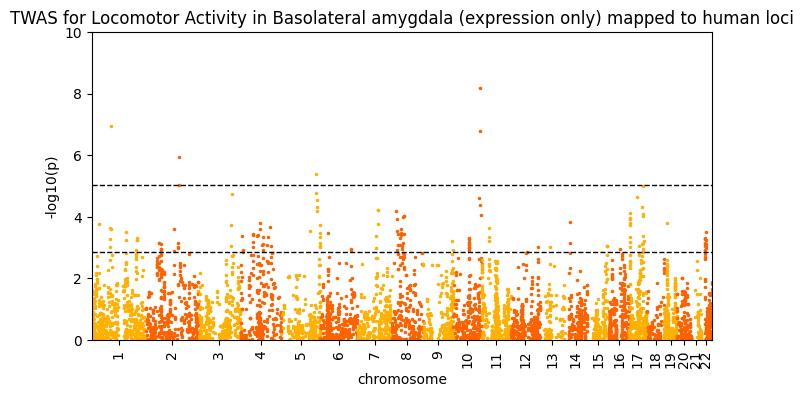

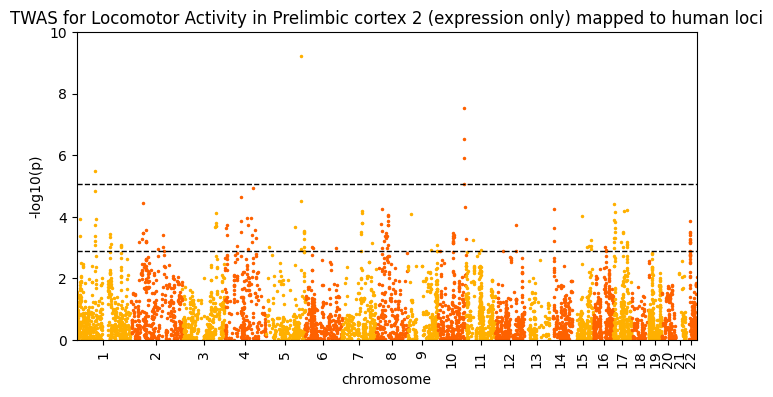

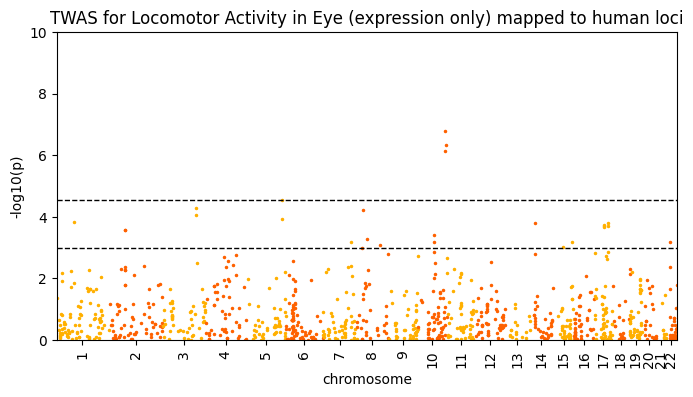

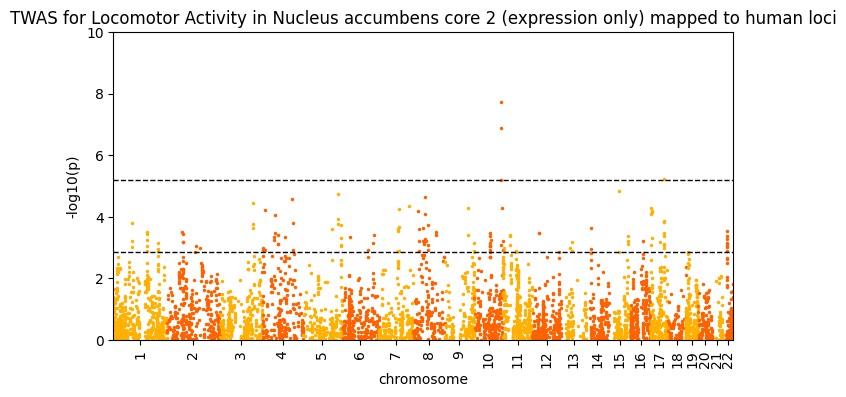

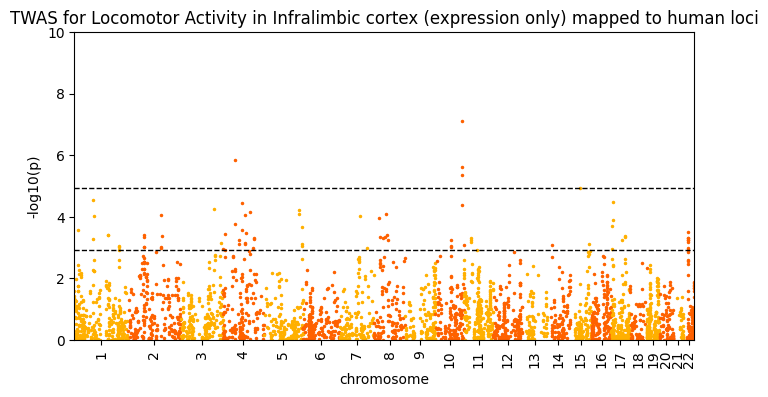

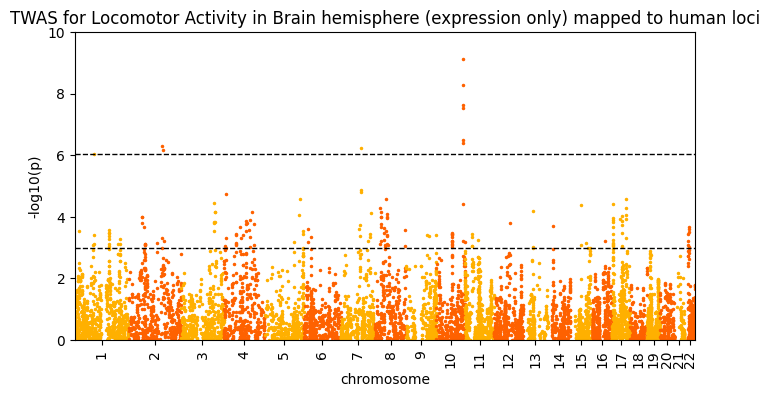

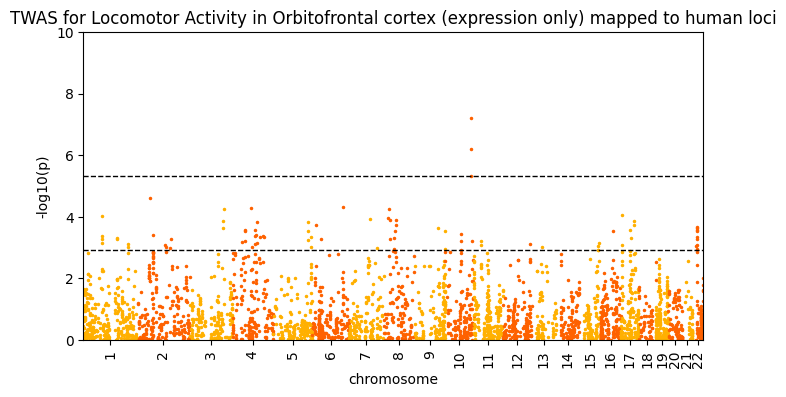

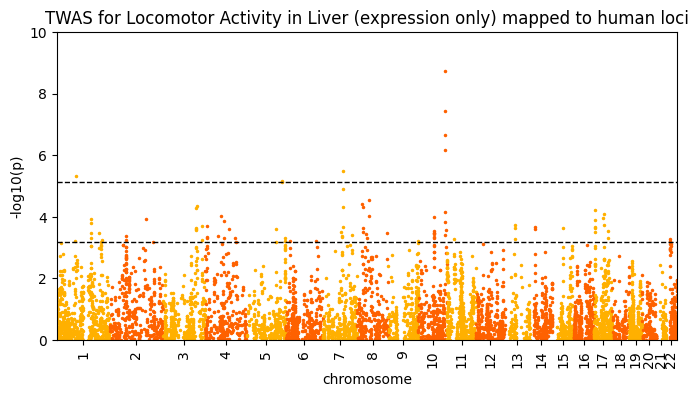

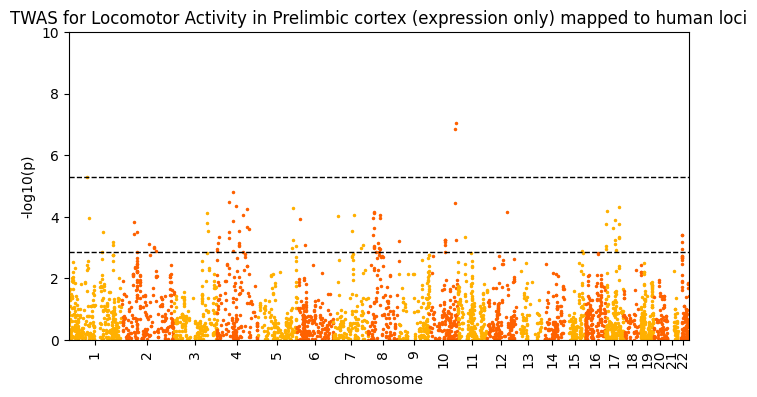

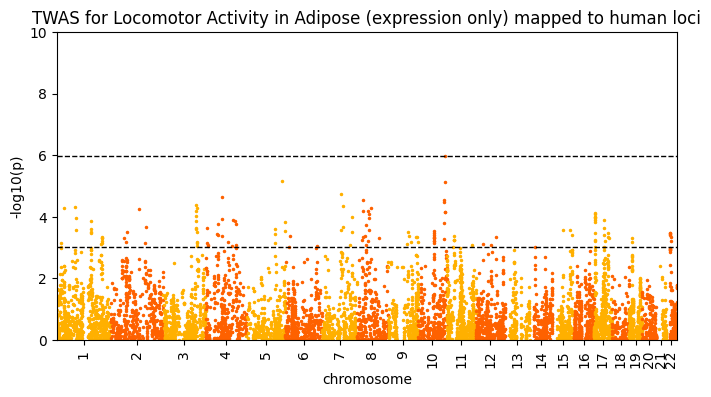

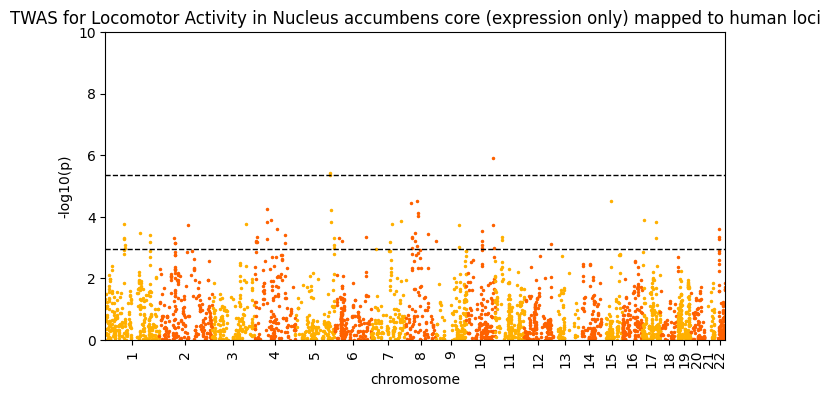

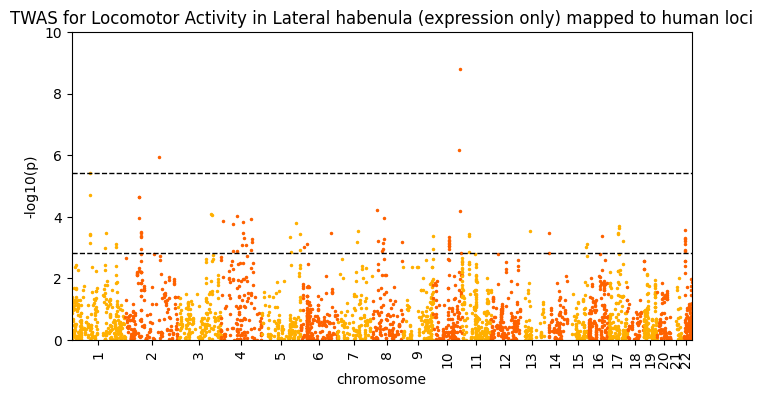

In [122]:
for h in set(t.TISSUE):
    k=h+'_exp'
    cutoff=-np.log10(max(twas_ortho[k][twas_ortho[k]['TWAS.Q']<0.05]['TWAS.P']))
    cutoff2=-np.log10(max(twas_ortho[k][twas_ortho[k]['TWAS.P']<0.05/len(twas_ortho[k])]['TWAS.P']))
    fig=plt.figure(figsize=(8,4))
    #fig, ax=plt.subplots(figsize=(10,4))
    j='loco'
    manhattan(pval=twas_ortho[k]['TWAS.P'],pos=twas_ortho[k]['hm_START'],chr=twas_ortho[k]['hm_CHR'],label='',
                        cut=0,lines=[cutoff, cutoff2],lines_colors=['black', 'black'], colors=[colour_dict[j], colour_dict[j+'_alt']],
                        lines_widths = [1,1], lines_styles = ["--","--"], markersize=3,top=10, plot_grid_lines=False)
    fig=plt.title('TWAS for Locomotor Activity in '+tissue_label[h]+' (expression only) mapped to human loci')
    fig=plt.ylabel('-log10(p)')
    plt.margins(x=0)
    #commented out- use to turn into miami plot
    #plt.gca().invert_yaxis()
    #plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
    fig=plt.xticks(rotation='vertical')
    if save_fig:
        plt.savefig('figures/manhattan_TWAS_map_to_human_'+j+'_tissue'+k+'_expression_only.png',dpi=600,bbox_inches='tight')